# Some EDA
Take a quick look at the data to find any interesting qualities. 

In [1]:
import pandas as pd
# For Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# Set up some standard plot qualities 
viridis = cm.get_cmap('viridis', lut=8)
viridis = viridis.colors
fig_size=(8,3)
dpi=200
fig_path = 'Data/Plots/'

In [2]:
data = pd.read_csv('Data/CSVs/Audio Legend Clean.csv',index_col='Unnamed: 0')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8842 entries, 0 to 8841
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   original   8842 non-null   object 
 1   actorid    8842 non-null   int64  
 2   statement  8842 non-null   int64  
 3   emotion    8842 non-null   object 
 4   sex        8842 non-null   object 
 5   race       7407 non-null   object 
 6   ethnicity  7407 non-null   object 
 7   time       8842 non-null   float64
 8   filename   8842 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 690.8+ KB


### Emotions

In [3]:
data['emotion'].value_counts()

anger        1463
happy        1462
fear         1461
disgust      1460
sad          1433
neutral      1182
surprised     191
calm          190
Name: emotion, dtype: int64

CREMA-D is significantly larger than RAVDESS and since it does not contain the `calm` or `surprised` labels, these emotions are highly underrepresented in the dataset. I went into the RADVESS voice clips and compared these to the other emotions. Overall, while I believe that `calm` can easily be added to the `neutral` label, the`surprised` label doesn’t really fit well with any of the other emotions and will be dropped.

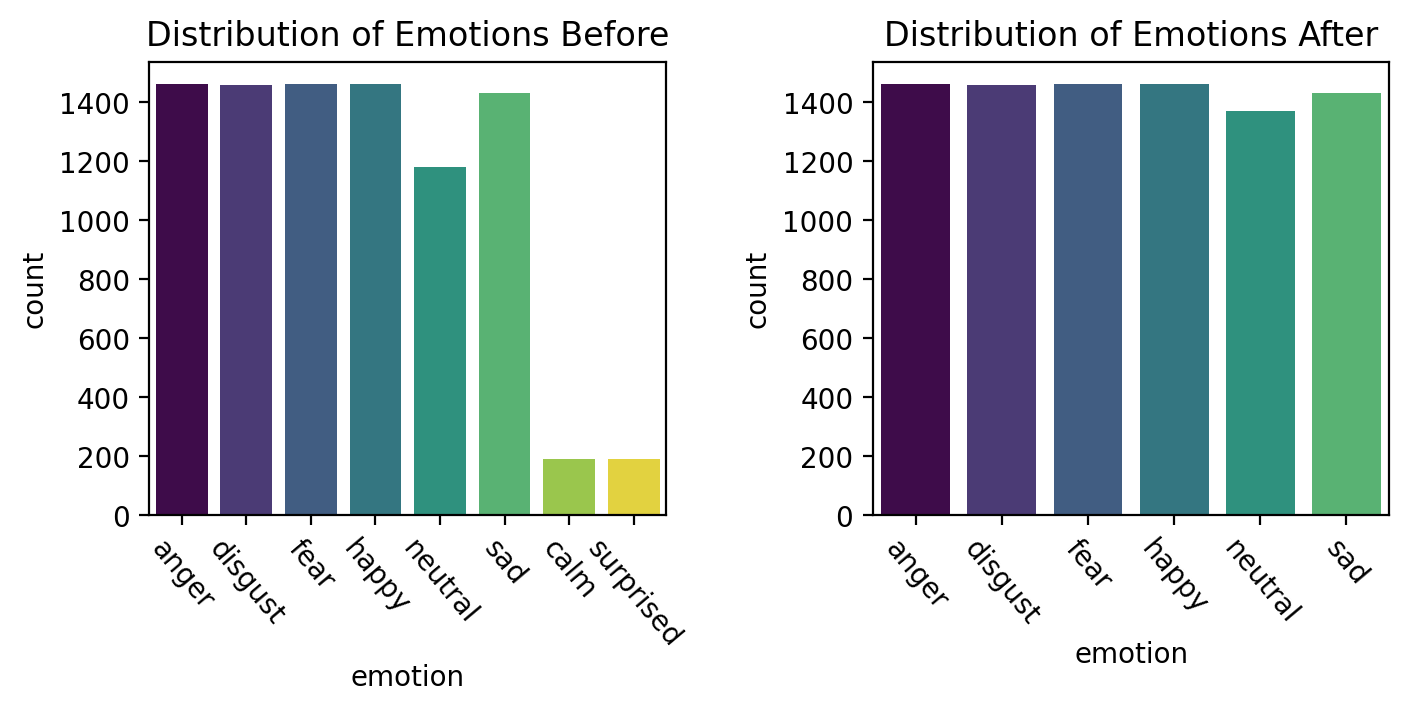

In [4]:
DIST_EMO = plt.figure(figsize=fig_size,dpi=dpi)
plt.subplots_adjust(wspace=0.4)
          
plt.subplot(121)
sns.countplot(data=data, x='emotion',palette=viridis)
plt.xticks(rotation=-50)
plt.title('Distribution of Emotions Before')

data['emotion'] = data['emotion'].str.replace('calm','neutral')
to_drop = data[data['emotion']=='surprised']
data = data.drop(index = to_drop.index)

plt.subplot(122)
sns.countplot(data=data, x='emotion',palette=viridis)
plt.title('Distribution of Emotions After')
plt.xticks(rotation=-50)

DIST_EMO.savefig(fig_path+'DIST Emotion', bbox_inches='tight');

### Statments

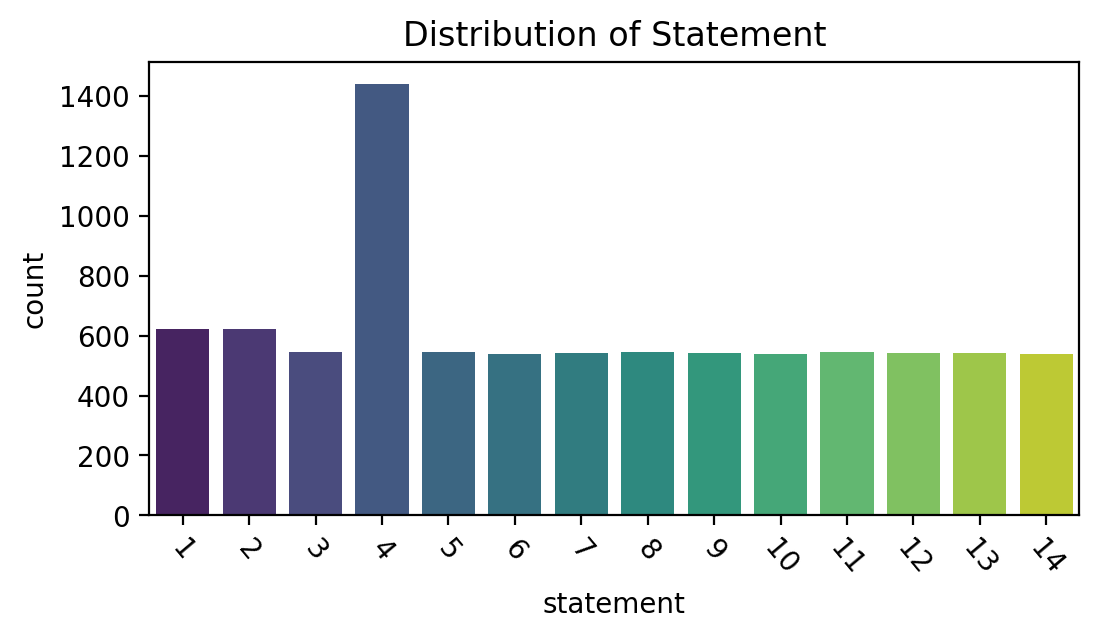

In [5]:
DIST_SMT = plt.figure(figsize=(6,3),dpi=dpi)

sns.countplot(data=data, x='statement',palette='viridis')
plt.xticks(rotation=-50)
plt.title('Distribution of Statement')

DIST_SMT.savefig(fig_path+'DIST Statement', bbox_inches='tight');

There are significantly more clips using phrase 4 (“It's eleven o'clock.”). At first I thought that this may have been due to an error in the renaming process, but upon investigation I came to the conclusion that there are indeed just twice as many clips using this phrase than the others. I’m not 100% sure why this may be, but currently my assumption is that it was the most commonly selected phrase by the CREMA-D actors due to the fact it's the shortest phrase offered.

For now I’ll let it be, but I’m going to be on the lookout for how this imbalance may affect the model.

### Race and Ethnicity
The RAVDESS dataset did not specifiy the race of each actor, so this is just an analysis of the CREMA-D entries.

In [6]:
# change label 'unknown' to 'other' for consistency 
races = data[['actorid','race','ethnicity']].drop_duplicates().dropna()
races['race'] = races['race'].str.replace('Unknown','Other')
races['race'] = races['race'].str.replace(' ','\n')

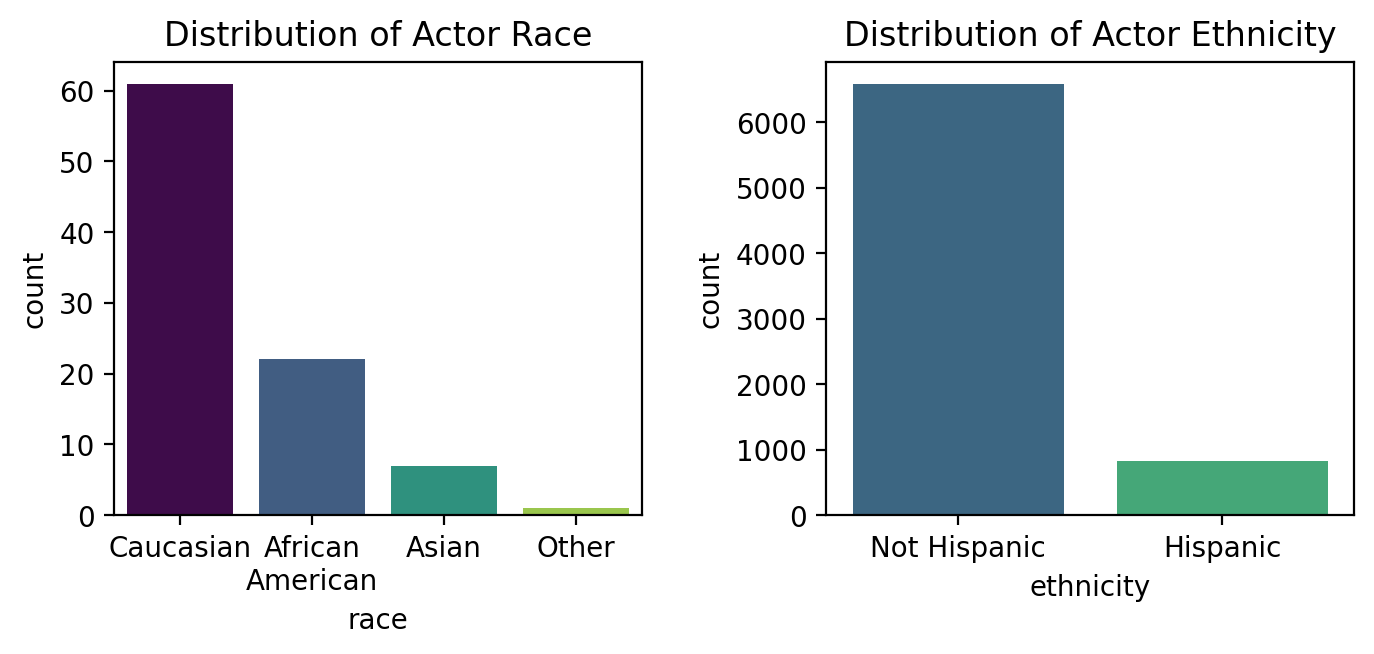

In [7]:
DIST_RAE_DAT = plt.figure(figsize=fig_size,dpi=dpi)
plt.subplots_adjust(wspace=0.35)
          
plt.subplot(121)
sns.countplot(data=races,x='race',palette=viridis[[0,2,4,6]])
plt.title('Distribution of Actor Race')

plt.subplot(122)
sns.countplot(data=data, x='ethnicity',palette='viridis')
plt.title('Distribution of Actor Ethnicity')

DIST_RAE_DAT.savefig(fig_path+'DIST R&E Data', bbox_inches='tight');

There’s definitely an imbalance in the diversity of the actors. Since the CREMA-D dataset comes from the U.S. lets see if at least reflects the diversity of the U.S.

In [8]:
import requests
from bs4 import BeautifulSoup

# 2019 U.S. Census Data
url = 'https://www.census.gov/quickfacts/fact/table/US/PST045219'
html = requests.get(url).text
soup = BeautifulSoup(html, 'html.parser')
soup = soup.findAll('tbody',{'data-topic':'Race and Hispanic Origin'})[0]
title = soup.findAll('a',{'class':"quickinfo icon-info-circled-1"})
percent = soup.findAll('td',{'data-geoid':"00"})

USData = []
for entry in range(len(title)):
    USData.append((title[entry]['data-title'],float(percent[entry]['data-value'])))
    
USRE = pd.DataFrame(USData,columns=['Race','Percent']).set_index('Race')

Race = USRE.iloc[range(6)]
Race = Race.sort_values('Percent',ascending=False).iloc[range(3)]
Race = Race.append(pd.Series({'Percent':100-Race.sum().values[0]},name='Other'),ignore_index=True)
Race.index = ['Caucasian','African\nAmerican','Asian','Other']

Ethnicity = USRE.iloc[[6,7]].sort_values('Percent',ascending=False)
Ethnicity.index = ['Not Hispanic','Hispanic']

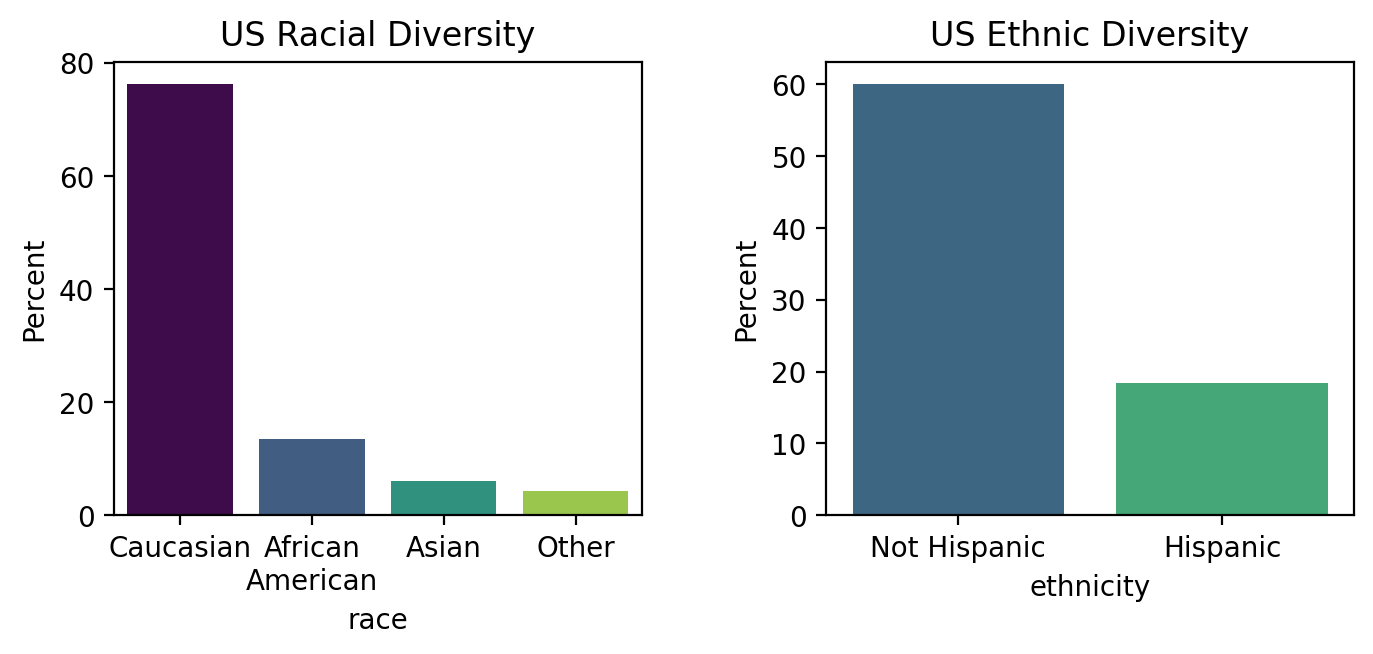

In [9]:
DIST_RAE_USA = plt.figure(figsize=fig_size,dpi=dpi)
plt.subplots_adjust(wspace=0.35)
          
plt.subplot(121)
sns.barplot(data=Race,x=Race.index,y='Percent',palette=viridis[[0,2,4,6]])
plt.title('US Racial Diversity')
plt.xlabel('race')

plt.subplot(122)
sns.barplot(data=Ethnicity,x=Ethnicity.index,y='Percent',palette='viridis')
plt.xlabel('ethnicity')
plt.title('US Ethnic Diversity')

DIST_RAE_USA.savefig(fig_path+'DIST R&E USA', bbox_inches='tight');

Seems roughly like the distribution of the actors reflects the diversity of the US population.

### Gender

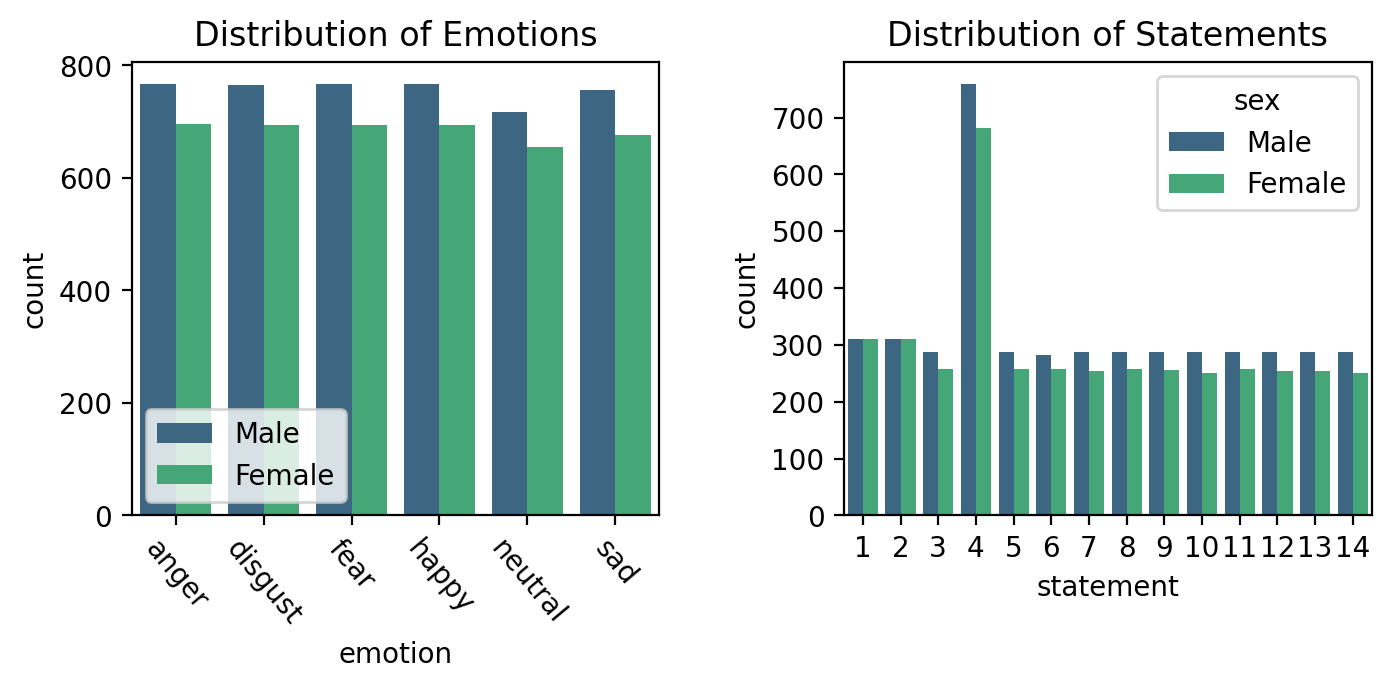

In [10]:
DIST_GEN = plt.figure(figsize=fig_size,dpi=dpi)
plt.subplots_adjust(wspace=0.35)
          
plt.subplot(121)
sns.countplot(data=data, x='emotion',hue='sex',palette='viridis')
plt.xticks(rotation=-50)
plt.legend(loc='lower left')
plt.title('Distribution of Emotions')

plt.subplot(122)
sns.countplot(data=data, x='statement',hue='sex',palette='viridis')
plt.title('Distribution of Statements')


DIST_GEN.savefig(fig_path+'DIST Gender', bbox_inches='tight');

Overall there are slightly more clips from male actors than female actors. Despite this, it appears that there's a pretty good balance among the emotions and statements. 

# Save Changes

In [11]:
data.to_csv('Data/CSVs/Audio Legend Clean.csv')